# Measuring GAN using Frechet Inception Distance

## Outline
- Introduction
- Load Model
    - Download Model
    - Init Model
- Generate Images
- Measuring Frechet Inception Distance
    1. Generate fake samples and (get) real samples
    2. Measure mean ($\mu$) and covariance ($\Sigma$) of each samples
    3. Calculate Frechet distance using the means and covariances


## Introduction

Frechet Inception Distance is a proposed evaluation method as an improvisation of Inception score. By using the same neural network as Inception score, Frechet Inception Distance measures the features extracted from real samples (usually come from real data sample) and fake samples (generated by model).

In [9]:
import os
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Folder Configuration
from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/My Drive/Colab Notebooks/DSC_UI_GAN/Batch1/W3/"

# Make dir if no exist
if not os.path.exists(ROOT):
    os.makedirs(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Model

We will use DCGAN model implemented in [Pytorch](https://github.com/pytorch/examples/tree/master/dcgan), with trained weights provided by [csinva/gan-pretrained-pytorch](https://github.com/csinva/gan-pretrained-pytorch)

### Download weights

In [2]:
%%bash

wget https://github.com/csinva/gan-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netD_epoch_199.pth -d netD_epoch_199.pth
wget https://github.com/csinva/gan-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netG_epoch_199.pth -d netG_epoch_199.pth

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'netD_epoch_199.pth' (UTF-8) -> 'netD_epoch_199.pth' (UTF-8)
--2019-11-21 08:41:58--  https://github.com/csinva/gan-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netD_epoch_199.pth
Resolving github.com (github.com)... 192.30.253.112
Caching github.com => 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
Created socket 5.
Releasing 0x0000561d7d4d0a60 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 5 to SSL handle 0x0000561d7d4f4000
certificate:
  subject: CN=github.com,O=GitHub\\, Inc.,L=San Francisco,ST=California,C=US,serialNumber=5157550,jurisdictionST=Delaware,jurisdictionC=US,businessCategory=Private Organization
  issuer:  CN=DigiCert SHA2 Extended Validation Server CA,OU=www.digicert.com,O=DigiCert Inc,C=US
X509 certificate successfully verified and matches host github

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [0]:
num_gpu = 1 if torch.cuda.is_available() else 0

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load("./netD_epoch_199.pth"))
G.load_state_dict(torch.load("./netG_epoch_199.pth"))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

## Generate samples from model

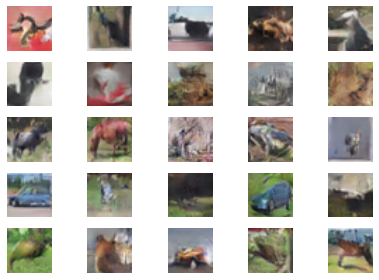

In [12]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5

for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i] * 0.5 + 0.5, interpolation='bilinear')
    plt.axis('off')
plt.tight_layout()
plt.savefig(ROOT + "dcgan_sample.png")
plt.show()

## Measure FID on model

FID implementation by [mseitzer](https://github.com/mseitzer/pytorch-fid)

### 1. Generate fake samples and get real data samples

In [13]:
%%bash 

wget https://github.com/mseitzer/pytorch-fid/raw/master/inception.py -d inception.py

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'inception.py' (UTF-8) -> 'inception.py' (UTF-8)
--2019-11-21 08:46:52--  https://github.com/mseitzer/pytorch-fid/raw/master/inception.py
Resolving github.com (github.com)... 192.30.255.112
Caching github.com => 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
Created socket 5.
Releasing 0x000055ba1cc2ca80 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 5 to SSL handle 0x000055ba1cc50000
certificate:
  subject: CN=github.com,O=GitHub\\, Inc.,L=San Francisco,ST=California,C=US,serialNumber=5157550,jurisdictionST=Delaware,jurisdictionC=US,businessCategory=Private Organization
  issuer:  CN=DigiCert SHA2 Extended Validation Server CA,OU=www.digicert.com,O=DigiCert Inc,C=US
X509 certificate successfully verified and matches host github.com

---request begin---
GET /mseitzer/pytorch-f

In [0]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.nn.functional import adaptive_avg_pool2d

from inception import InceptionV3

from scipy import linalg
from tqdm import tqdm

In [15]:
n_samples = 1000

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10 = datasets.CIFAR10('./data', transform=transform, download=True)
cifar10_loader = DataLoader(cifar10, batch_size=n_samples, shuffle=True)
cifar10_iter = iter(cifar10_loader)

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

0it [00:00, ?it/s]

170500096it [00:04, 40286630.94it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [16]:
real_samples, _ = cifar10_iter.next()
real_samples.shape

torch.Size([1000, 3, 32, 32])

In [17]:
fixed_noise = torch.randn(n_samples, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)
fake_images.shape

torch.Size([1000, 3, 32, 32])

### 2. Calculate mean and covariance of Inception activations on each samples

In [0]:
def get_activations(files, model, batch_size=50, dims=2048, cuda=False):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of images data
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    n_batches = len(files) // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))

    for i in tqdm(range(n_batches)):
        print('\rPropagating batch %d/%d' % (i + 1, n_batches), end='', flush=True)
        start = i * batch_size
        end = start + batch_size

        images = files[start:end]

        # batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            # batch = batch.cuda()
            batch = images.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(batch_size, -1)

    print(' done')

    return pred_arr

In [0]:
def calculate_activation_statistics(files, model, batch_size=50, dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Size of batch per processing in Inception modl
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    
    return mu, sigma

In [22]:
dims = 2048
batch_size = 50
cuda = torch.cuda.is_available()

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

model = InceptionV3([block_idx], normalize_input=False)
if cuda:
    model.cuda()

m_real, sigma_real = calculate_activation_statistics(real_samples, model, batch_size, dims, cuda)
m_fake, sigma_fake = calculate_activation_statistics(fake_images, model, batch_size, dims, cuda)

  0%|          | 0/20 [00:00<?, ?it/s]

Propagating batch 1/20

  5%|▌         | 1/20 [00:00<00:03,  4.99it/s]

Propagating batch 2/20

 10%|█         | 2/20 [00:00<00:03,  5.66it/s]

Propagating batch 3/20

 15%|█▌        | 3/20 [00:00<00:02,  6.26it/s]

Propagating batch 4/20

 20%|██        | 4/20 [00:00<00:02,  6.79it/s]

Propagating batch 5/20

 25%|██▌       | 5/20 [00:00<00:02,  7.21it/s]

Propagating batch 6/20

 30%|███       | 6/20 [00:00<00:01,  7.54it/s]

Propagating batch 7/20

 35%|███▌      | 7/20 [00:00<00:01,  7.80it/s]

Propagating batch 8/20

 40%|████      | 8/20 [00:01<00:01,  7.98it/s]

Propagating batch 9/20

 45%|████▌     | 9/20 [00:01<00:01,  8.12it/s]

Propagating batch 10/20

 50%|█████     | 10/20 [00:01<00:01,  8.19it/s]

Propagating batch 11/20

 55%|█████▌    | 11/20 [00:01<00:01,  8.27it/s]

Propagating batch 12/20

 60%|██████    | 12/20 [00:01<00:00,  8.30it/s]

Propagating batch 13/20

 65%|██████▌   | 13/20 [00:01<00:00,  8.34it/s]

Propagating batch 14/20

 70%|███████   | 14/20 [00:01<00:00,  8.37it/s]

Propagating batch 15/20

 75%|███████▌  | 15/20 [00:01<00:00,  8.40it/s]

Propagating batch 16/20

 80%|████████  | 16/20 [00:01<00:00,  8.42it/s]

Propagating batch 17/20

 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

Propagating batch 18/20

 90%|█████████ | 18/20 [00:02<00:00,  8.45it/s]

Propagating batch 19/20

 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

Propagating batch 20/20

100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


 done


  0%|          | 0/20 [00:00<?, ?it/s]

Propagating batch 1/20

  5%|▌         | 1/20 [00:00<00:02,  8.53it/s]

Propagating batch 2/20

 10%|█         | 2/20 [00:00<00:02,  8.49it/s]

Propagating batch 3/20

 15%|█▌        | 3/20 [00:00<00:02,  8.49it/s]

Propagating batch 4/20

 20%|██        | 4/20 [00:00<00:01,  8.49it/s]

Propagating batch 5/20

 25%|██▌       | 5/20 [00:00<00:01,  8.49it/s]

Propagating batch 6/20

 30%|███       | 6/20 [00:00<00:01,  8.49it/s]

Propagating batch 7/20

 35%|███▌      | 7/20 [00:00<00:01,  8.49it/s]

Propagating batch 8/20

 40%|████      | 8/20 [00:00<00:01,  8.48it/s]

Propagating batch 9/20

 45%|████▌     | 9/20 [00:01<00:01,  8.48it/s]

Propagating batch 10/20

 50%|█████     | 10/20 [00:01<00:01,  8.48it/s]

Propagating batch 11/20

 55%|█████▌    | 11/20 [00:01<00:01,  8.47it/s]

Propagating batch 12/20

 60%|██████    | 12/20 [00:01<00:00,  8.47it/s]

Propagating batch 13/20

 65%|██████▌   | 13/20 [00:01<00:00,  8.47it/s]

Propagating batch 14/20

 70%|███████   | 14/20 [00:01<00:00,  8.48it/s]

Propagating batch 15/20

 75%|███████▌  | 15/20 [00:01<00:00,  8.48it/s]

Propagating batch 16/20

 80%|████████  | 16/20 [00:01<00:00,  8.48it/s]

Propagating batch 17/20

 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

Propagating batch 18/20

 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

Propagating batch 19/20

 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

Propagating batch 20/20

100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


 done


## Measure Frechet distance given the means and covariances

According to the [paper](https://arxiv.org/pdf/1706.08500.pdf)

![Excerpt from paper](https://i.stack.imgur.com/9gUDE.png)

In [0]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance. Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : The sample mean over activations, precalculated on an generative data set.
    -- mu2   : The sample mean over activations, precalculated on a representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on a representative data set.
    Returns:
    -- The Frechet distance calculated
    """
    # Check dimension of mu and sigma 
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    # Calculate mu_1 - mu_2
    diff = mu1 - mu2

    # Calculate square root mean of sigma_1 * sigma_2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Product might be almost singular
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    # Get trace of covmean
    tr_covmean = np.trace(covmean)

    # Return the calculated FID result
    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

In [24]:
fid_value = calculate_frechet_distance(m_real, sigma_real, m_fake, sigma_fake)

print('FID score of model: {:3.5f}'.format(fid_value))

FID score of model: 77.63838
